# Fitting Thermoelectric data
Models and data are from Danny/Kedar.

## Import Modules, Functions, and Data

`functions.py` has the Python implementations of all the helper functions (I used a previously written package, `fdint`, for the Fermi-Dirac integrals).

In [1]:
import numpy as np
from functions import *

In [2]:
celldata = {}
celldata['xdata'] = np.loadtxt('xdata.csv',delimiter=',')
celldata['ydata'] = np.loadtxt('ydata.csv',delimiter=',')
celldata['n'] = 40

## Validate Python implementation
I did a test evaluation in Matlab and Python with the same input parameters. Let's import the results and compare to make sure we're getting the same thing.

In [3]:
test_in = [-2.499946233286e1,1.833885014595e-3,-2.2588468610036e-3,8.6217332036812e-4]
test_y,test_S,test_Rou=tefunnew(celldata,test_in)
matlab_y = np.loadtxt('matlab_y.csv',delimiter=',')
matlab_S = np.loadtxt('matlab_S.csv',delimiter=',')
matlab_Rou = np.loadtxt('matlab_Rou.csv',delimiter=',')

In [4]:
y_pct_diff=(test_y-matlab_y)/matlab_y
print('There is an average of a %.2f%% difference (with a standard deviation of %.2f%%) between the Matlab and Python implementations in the y output.'%(round(100.0*np.mean(y_pct_diff),2),round(100.0*np.std(y_pct_diff),2)))

There is an average of a -3.27% difference (with a standard deviation of 0.05%) between the Matlab and Python implementations in the y output.


In [5]:
S_pct_diff=(test_S-matlab_S)/matlab_S
print('There is an average of a %.2f%% difference (with a standard deviation of %.2f%%) between the Matlab and Python implementations in the S output.'%(round(100.0*np.mean(S_pct_diff),2),round(100.0*np.std(S_pct_diff),2)))

There is an average of a -1.65% difference (with a standard deviation of 0.03%) between the Matlab and Python implementations in the S output.


In [6]:
Rou_pct_diff=(test_Rou-matlab_Rou)/matlab_Rou
print('There is an average of a %.3f%% difference (with a standard deviation of %.3f%%) between the Matlab and Python implementations in the Rou output.'%(round(100.0*np.mean(Rou_pct_diff),3),round(100.0*np.std(Rou_pct_diff),3)))

There is an average of a -0.051% difference (with a standard deviation of 0.002%) between the Matlab and Python implementations in the Rou output.


Okay, so the differences aren't nothing, but they're small enough that I think we can work with them.

## Fitting with Bayesim
Now let's do a fit to the data using the grid approach implemented in the `bayesim` code.
### Import Things

In [7]:
import sys
sys.path.append('../../')
import bayesim.model as bym
import bayesim.param_list as byp
import functions as tefcns # model functions implemented in a separate file to keep this notebook tidy
import deepdish as dd # for interacting with HDF5 files
from joblib import Parallel, delayed # to parallelize model computations

### Initialize
First, we set up the list of parameters to be fit and their ranges.

In [8]:
fp = byp.param_list()
"""
fp.add_fit_param(name='P0', val_range=[1e-34,1e-20], spacing='log', length=28, units='sec.')
fp.add_fit_param(name='fs', val_range=[-1,2], length=21, units='eV')
fp.add_fit_param(name='r', val_range=[-1,2], length=21)
fp.add_fit_param(name='Z', val_range=[-10,10], length=20)
"""
fp.add_fit_param(name='P0', val_range=[1e-34,1e-20], spacing='log', length=7, units='sec.')
fp.add_fit_param(name='fs', val_range=[-1,2], length=5, units='eV')
fp.add_fit_param(name='r', val_range=[-1,2], length=5)
fp.add_fit_param(name='Z', val_range=[-10,10], length=5)


Next, define the experimental conditions.

In [9]:
ec = ['T','R','n']

Now, set up the `bayesim.model` object. All we need to feed in are the parameters, experimental conditions, and name of the output variable.

In [10]:
m = bym.model(params=fp,ec=ec,output_var='P')

### Attach Experimental Observations
The next thing to do is to attach the observed data. I reformatted it to work with `bayesim` and saved an HDF5 file. You can see the format in the Excel sheet `TE_expt_data.xlsx`. Here I use only every third point (integer values of resistances) to speed up model computation and also because that's probably enough data.

In [11]:
#m.attach_observations(fpath='TE_expt_data.h5')
m.attach_observations(fpath='TE_expt_data_sparse.h5')

Identified experimental conditions as ['n', 'T', 'R']. If this is wrong, rerun and explicitly specify them with attach_ec (make sure they match data file columns) or remove extra columns from data file.


### Attaching the Model
Next, we attach the model. In this example I'll precompute the modeled data and attach a file with the outputs. You could also attach the function used to do the modeling, but the code can't currently parallelize those computations so I do it outside `bayesim` to take advantage of both cores on my laptop.
First we write out a file with the list of all simulation points. (it's good practice to write this out rather than keep it only as a Python object so we can pick up where we left off later)

This next cell should take about 30 seconds to evaluate, but if you don't want to do the model computations yourself you can skip it.

In [12]:
#m.list_model_pts_to_run('./sim_list.h5')

The code in the next cell will actually do the model computations. On my two-core laptop, it takes about 24 minutes to evaluate. Assuming your processor supports multithreading (almost all modern ones do), you should set `n_jobs` to be twice the number of cores on your machine if you want to run this cell efficiently.

You can also just skip this cell and instead evaluate the following one to just load in the results of the computation that I did. :)

In [13]:
#sim_list = dd.io.load('./sim_list.h5')
#outputs=Parallel(n_jobs=4,verbose=7)(delayed(tefunnew_singlept)(sim[1][m.ec_names],sim[1][m.param_names]) for sim in sim_list.iterrows())
#sim_list['P'] = outputs
#dd.io.save('sim_outputs.h5',sim_list)

In [14]:
#m.attach_model(mode='file',fpath='sim_outputs.h5')

On a sparse grid like this, it's important that the error values we use (i.e. standard deviation of Gaussians used for likelihood) are big enough to reach between boxes. This function computes the distance in output variable between model boxes at every experimental condition point and adds it to a column in model_data called 'deltas.'

In [15]:
#m.calc_model_gradients()
#m.model_data.sample(10)

As you can see, because our grid is super sparse, the deltas are actually larger than the actual output values right now!

### First Bayes!
The `run` function randomizes the order of observations and stops feeding them in by default when 80% of the probability mass resides in 5% of the parameter space. These parameters can be tuned using the input parameters `th_pm` (default 0.8) and `th_pv` (default 0.05).

__If you don't want to have to run the new simulations yourself (they'll take longer than the first batch), don't run the code in this cell - I just left it so you can see what *was* run.__

(Because the `run` function randomizes observations, if you run it, the subdivided cells will likely not match exactly and you'll get an error if you try to just load in the results from my new simulation run)

In [16]:
#m.run()
#m.save_state(filename='states/state_1.h5')

Here we just load the model state that I saved and carry onward.

In [17]:
#m = bym.model(load_state=True, state_file='states/state_1.h5')
#%matplotlib inline
#m.probs.visualize()

I'm not sure what's going on with the upper left box right now. I'll fix it...

### Subdivide!
I've found that 0.001 seems to be a reasonable threshold probability for boxes to subdivide on the first round so that's the default value, but you can feed in other numbers for `threshold_prob` to this function.

Note that the `subdivide` function divides not only boxes meeting the threshold but any boxes immediately neighboring those. It will also write out an HDF5 of the new simulations that need to be run; that step can take awhile (this cell takes a few minutes on my computer) because it's writing every combination of new parameter points AND experimental condition points.

Again, if you don't want to run it, you can skip this cell and just use the `load_state` line in the next cell to start where I left off.

In [18]:
#m.subdivide()
#m.save_state('states/state_2.h5')

It's worth noting that there were originally 875 boxes in our super sparse grid, so in this case a majority of them were subdivided, which isn't too surprising.

### Run (more simulations and then) more inference!
I ran the batch of new simulations on Peregrine; the results are in the file `new_sim_outputs_.h5` which we'll load in here to do the next round of inference.

This cell takes about a minute to run.

In [19]:
#m = bym.model(load_state=True,state_file='states/state_2.h5')
#m.attach_model(mode='add',fpath='new_sim_outputs_1.h5')
#m.save_state('states/state_3.h5')

In [20]:
#m = bym.model(load_state=True,state_file='states/state_3.h5')
#m.run()

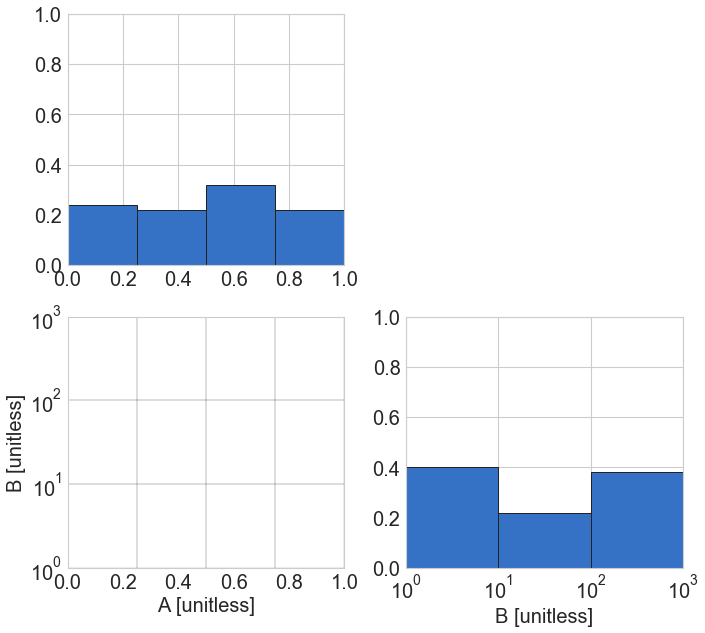

In [21]:
fp = byp.param_list()
fp.add_fit_param(name='A',val_range=[0,1],length=4)
fp.add_fit_param(name='B',val_range=[1,1000],length=3,spacing='log')
tm = bym.model(params=fp,ec=['C'],output_var='O')
new_probs = [0.05,0.02,0.17,0.06,0.07,0.09,0.23,0.05,0.04,0.06,0.08,0.08]
tm.probs.points['prob']=new_probs
from jupyterthemes import jtplot
jtplot.style('default')
tm.probs.visualize(just_grid=True)

In [22]:
tm.probs.points

,A,A_min,A_max,B,B_min,B_max,new,prob,num_sub
0,0.125,0.00,0.25,3.162278,1.0,10.0,1.0,0.05,0
1,0.125,0.00,0.25,31.622777,10.0,100.0,1.0,0.02,0
2,0.125,0.00,0.25,316.227766,100.0,1000.0,1.0,0.17,0
3,0.375,0.25,0.50,3.162278,1.0,10.0,1.0,0.06,0
4,0.375,0.25,0.50,31.622777,10.0,100.0,1.0,0.07,0
5,0.375,0.25,0.50,316.227766,100.0,1000.0,1.0,0.09,0
6,0.625,0.50,0.75,3.162278,1.0,10.0,1.0,0.23,0
7,0.625,0.50,0.75,31.622777,10.0,100.0,1.0,0.05,0
8,0.625,0.50,0.75,316.227766,100.0,1000.0,1.0,0.04,0
9,0.875,0.75,1.00,3.162278,1.0,10.0,1.0,0.06,0


In [23]:
tm.probs.subdivide(0.2)

1 box(es) with probability > 0.2 and 3 neighboring boxes subdivided!


(        A  A_min  A_max          B      B_min       B_max  new    prob  \
 0  0.5625  0.500  0.625   1.778279   1.000000    3.162278  1.0  0.0575   
 1  0.5625  0.500  0.625   5.623413   3.162278   10.000000  1.0  0.0575   
 2  0.6875  0.625  0.750   1.778279   1.000000    3.162278  1.0  0.0575   
 3  0.6875  0.625  0.750   5.623413   3.162278   10.000000  1.0  0.0575   
 0  0.3125  0.250  0.375   1.778279   1.000000    3.162278  1.0  0.0150   
 1  0.3125  0.250  0.375   5.623413   3.162278   10.000000  1.0  0.0150   
 2  0.4375  0.375  0.500   1.778279   1.000000    3.162278  1.0  0.0150   
 3  0.4375  0.375  0.500   5.623413   3.162278   10.000000  1.0  0.0150   
 0  0.5625  0.500  0.625  17.782794  10.000000   31.622777  1.0  0.0125   
 1  0.5625  0.500  0.625  56.234133  31.622777  100.000000  1.0  0.0125   
 2  0.6875  0.625  0.750  17.782794  10.000000   31.622777  1.0  0.0125   
 3  0.6875  0.625  0.750  56.234133  31.622777  100.000000  1.0  0.0125   
 0  0.8125  0.750  0.875 

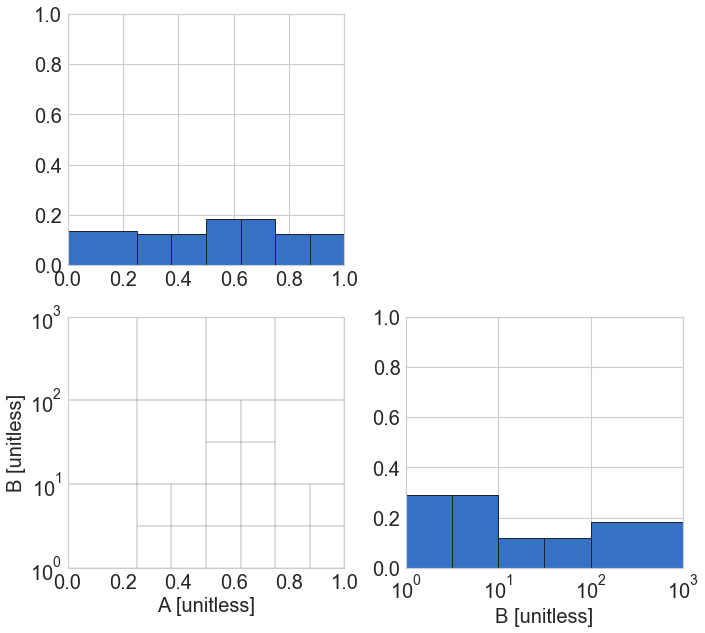

In [24]:
tm.probs.visualize(just_grid=True)

In [38]:
tm.probs.points.head(10)

,A,A_min,A_max,B,B_min,B_max,new,prob,num_sub,model_output
0,0.1250,0.000,0.250,3.162278,1.000000,10.000000,0.0,0.0500,0,86.0
1,0.1250,0.000,0.250,31.622777,10.000000,100.000000,0.0,0.0200,0,45.0
2,0.1250,0.000,0.250,316.227766,100.000000,1000.000000,0.0,0.1700,0,77.0
3,0.3125,0.250,0.375,1.778279,1.000000,3.162278,1.0,0.0150,1,3.0
4,0.3125,0.250,0.375,5.623413,3.162278,10.000000,1.0,0.0150,1,33.0
5,0.3750,0.250,0.500,31.622777,10.000000,100.000000,0.0,0.0700,0,66.0
6,0.3750,0.250,0.500,316.227766,100.000000,1000.000000,0.0,0.0900,0,35.0
7,0.4375,0.375,0.500,1.778279,1.000000,3.162278,1.0,0.0150,1,63.0
8,0.4375,0.375,0.500,5.623413,3.162278,10.000000,1.0,0.0150,1,99.0
9,0.5625,0.500,0.625,1.778279,1.000000,3.162278,1.0,0.0575,1,41.0


In [ ]:
# test non-gridded gradient calc!

In [35]:
#pt = points.iloc[17]
def find_box(pt,bm,grid):
    points_min_grps = {p:grid.groupby(by=[p+'_min']) for p in bm.param_names}
    points_max_grps = {p:grid.groupby(by=[p+'_max']) for p in bm.param_names}
    min_match = [set(np.concatenate([points_min_grps[p].groups[k] for k in list(points_min_grps[p].groups.keys()) if pt[p]>k])) for p in bm.param_names]
    max_match = [set(np.concatenate([points_max_grps[p].groups[k] for k in list(points_max_grps[p].groups.keys()) if pt[p]<k])) for p in bm.param_names]
    min_match = min_match[0].intersection(*min_match[1:])
    max_match = max_match[0].intersection(*max_match[1:])
    box_ind = list(min_match.intersection(max_match))
    if len(box_ind)==0:
        return np.nan
    else:
        return box_ind[0]

In [36]:
import pandas as pd
data = []
for a in A_vals:
    for b in B_vals:
        pt = {'A':a,'B':b}
        data.append([a,b,find_box(pt,tm,points)])
        #print(pt,find_box(pt,tm,points))
pd.DataFrame.from_records(data=data,columns=tm.param_names+['ind'])

,A,B,ind
0,0.1250,1.778279,0.0
1,0.1250,3.162278,0.0
2,0.1250,5.623413,0.0
3,0.1250,17.782794,1.0
4,0.1250,31.622777,1.0
5,0.1250,56.234133,1.0
6,0.1250,316.227766,2.0
7,0.3125,1.778279,3.0
8,0.3125,3.162278,NaN
9,0.3125,5.623413,4.0
